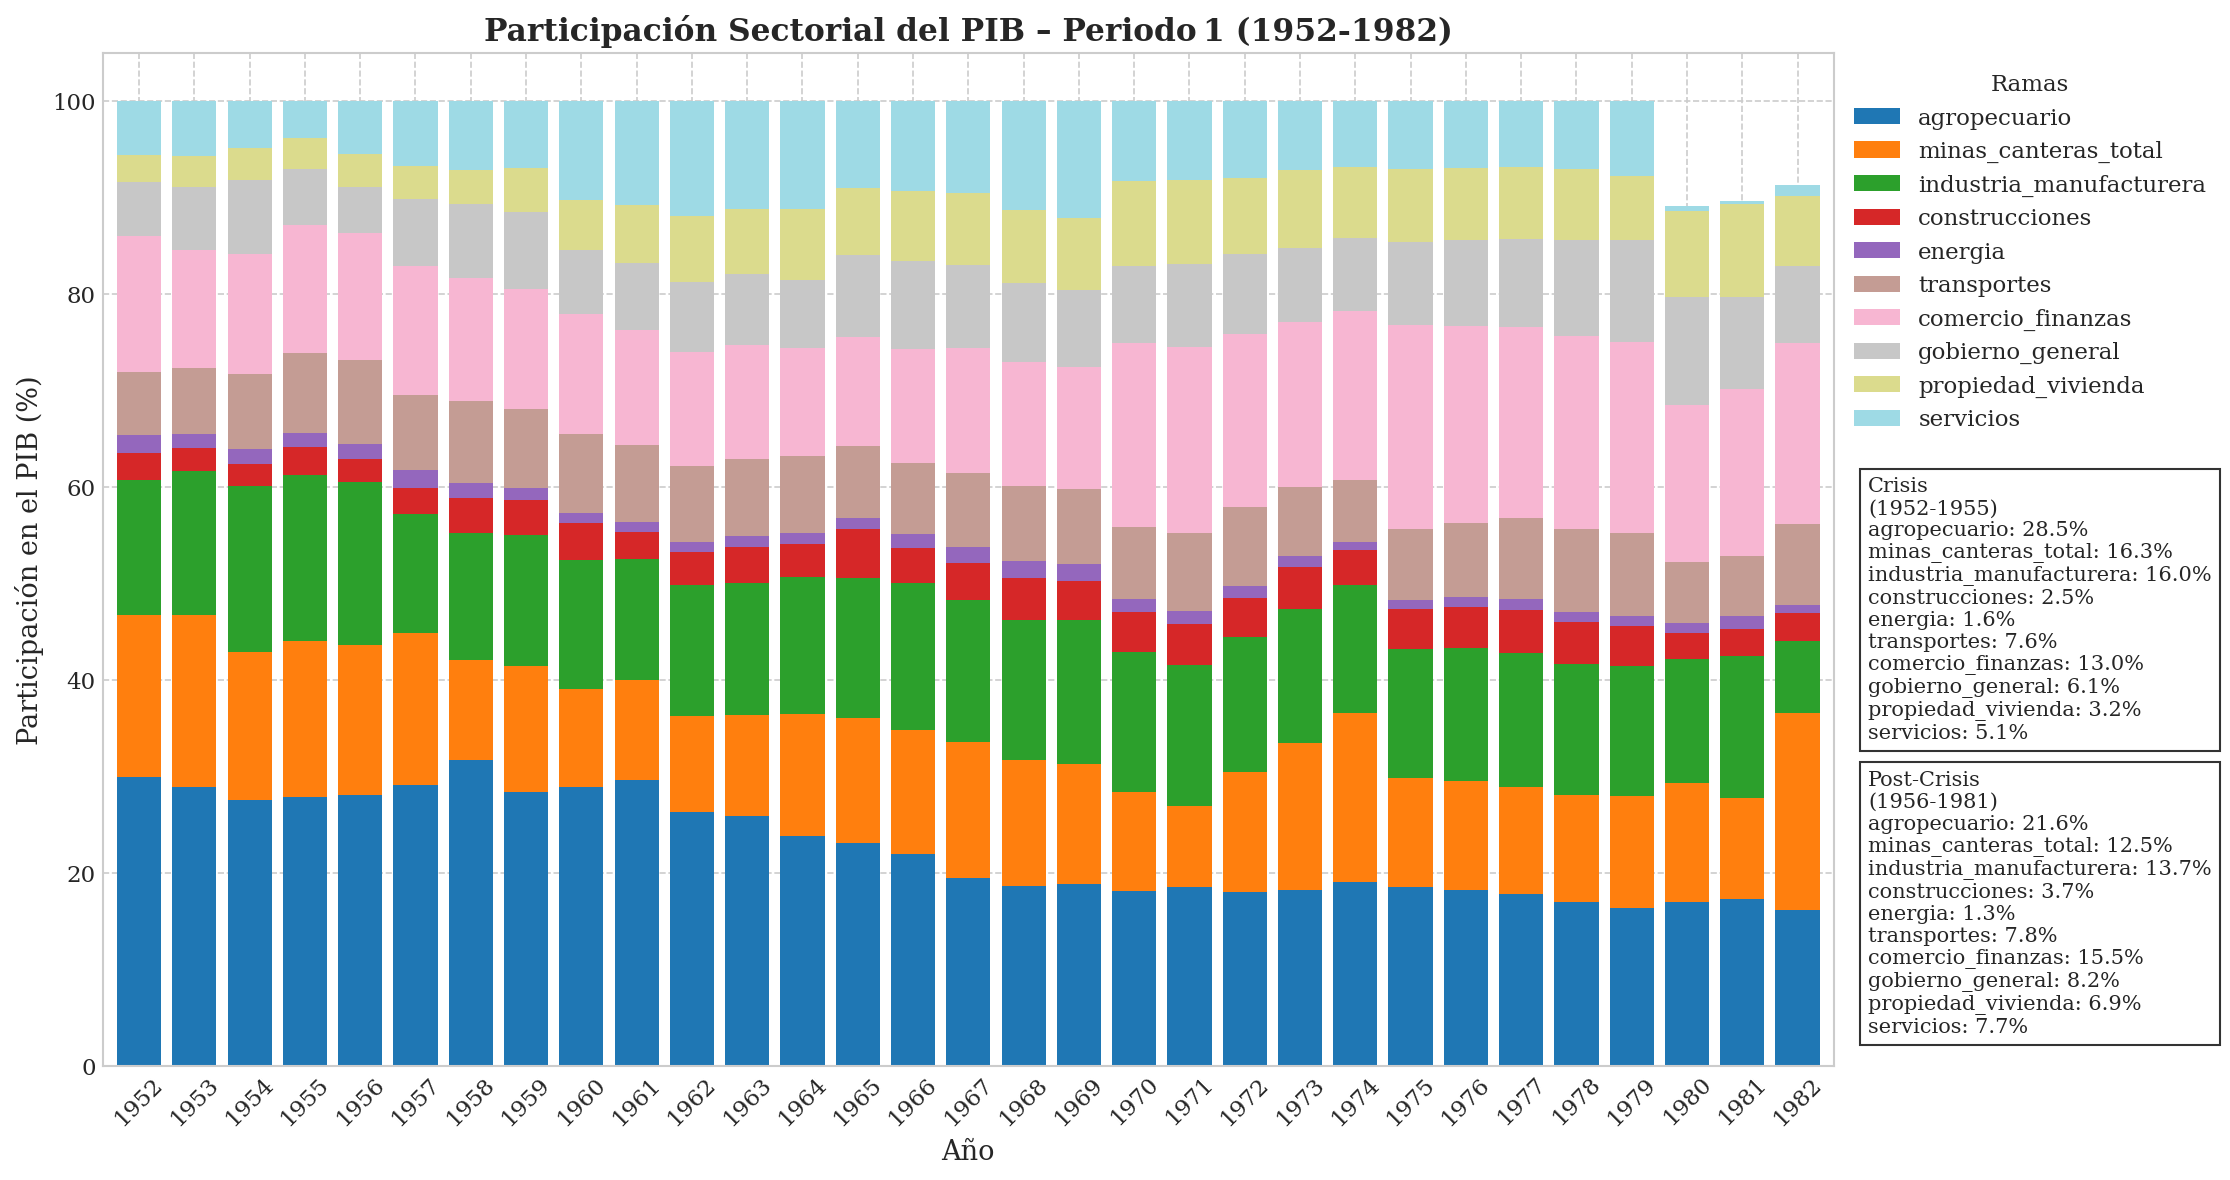

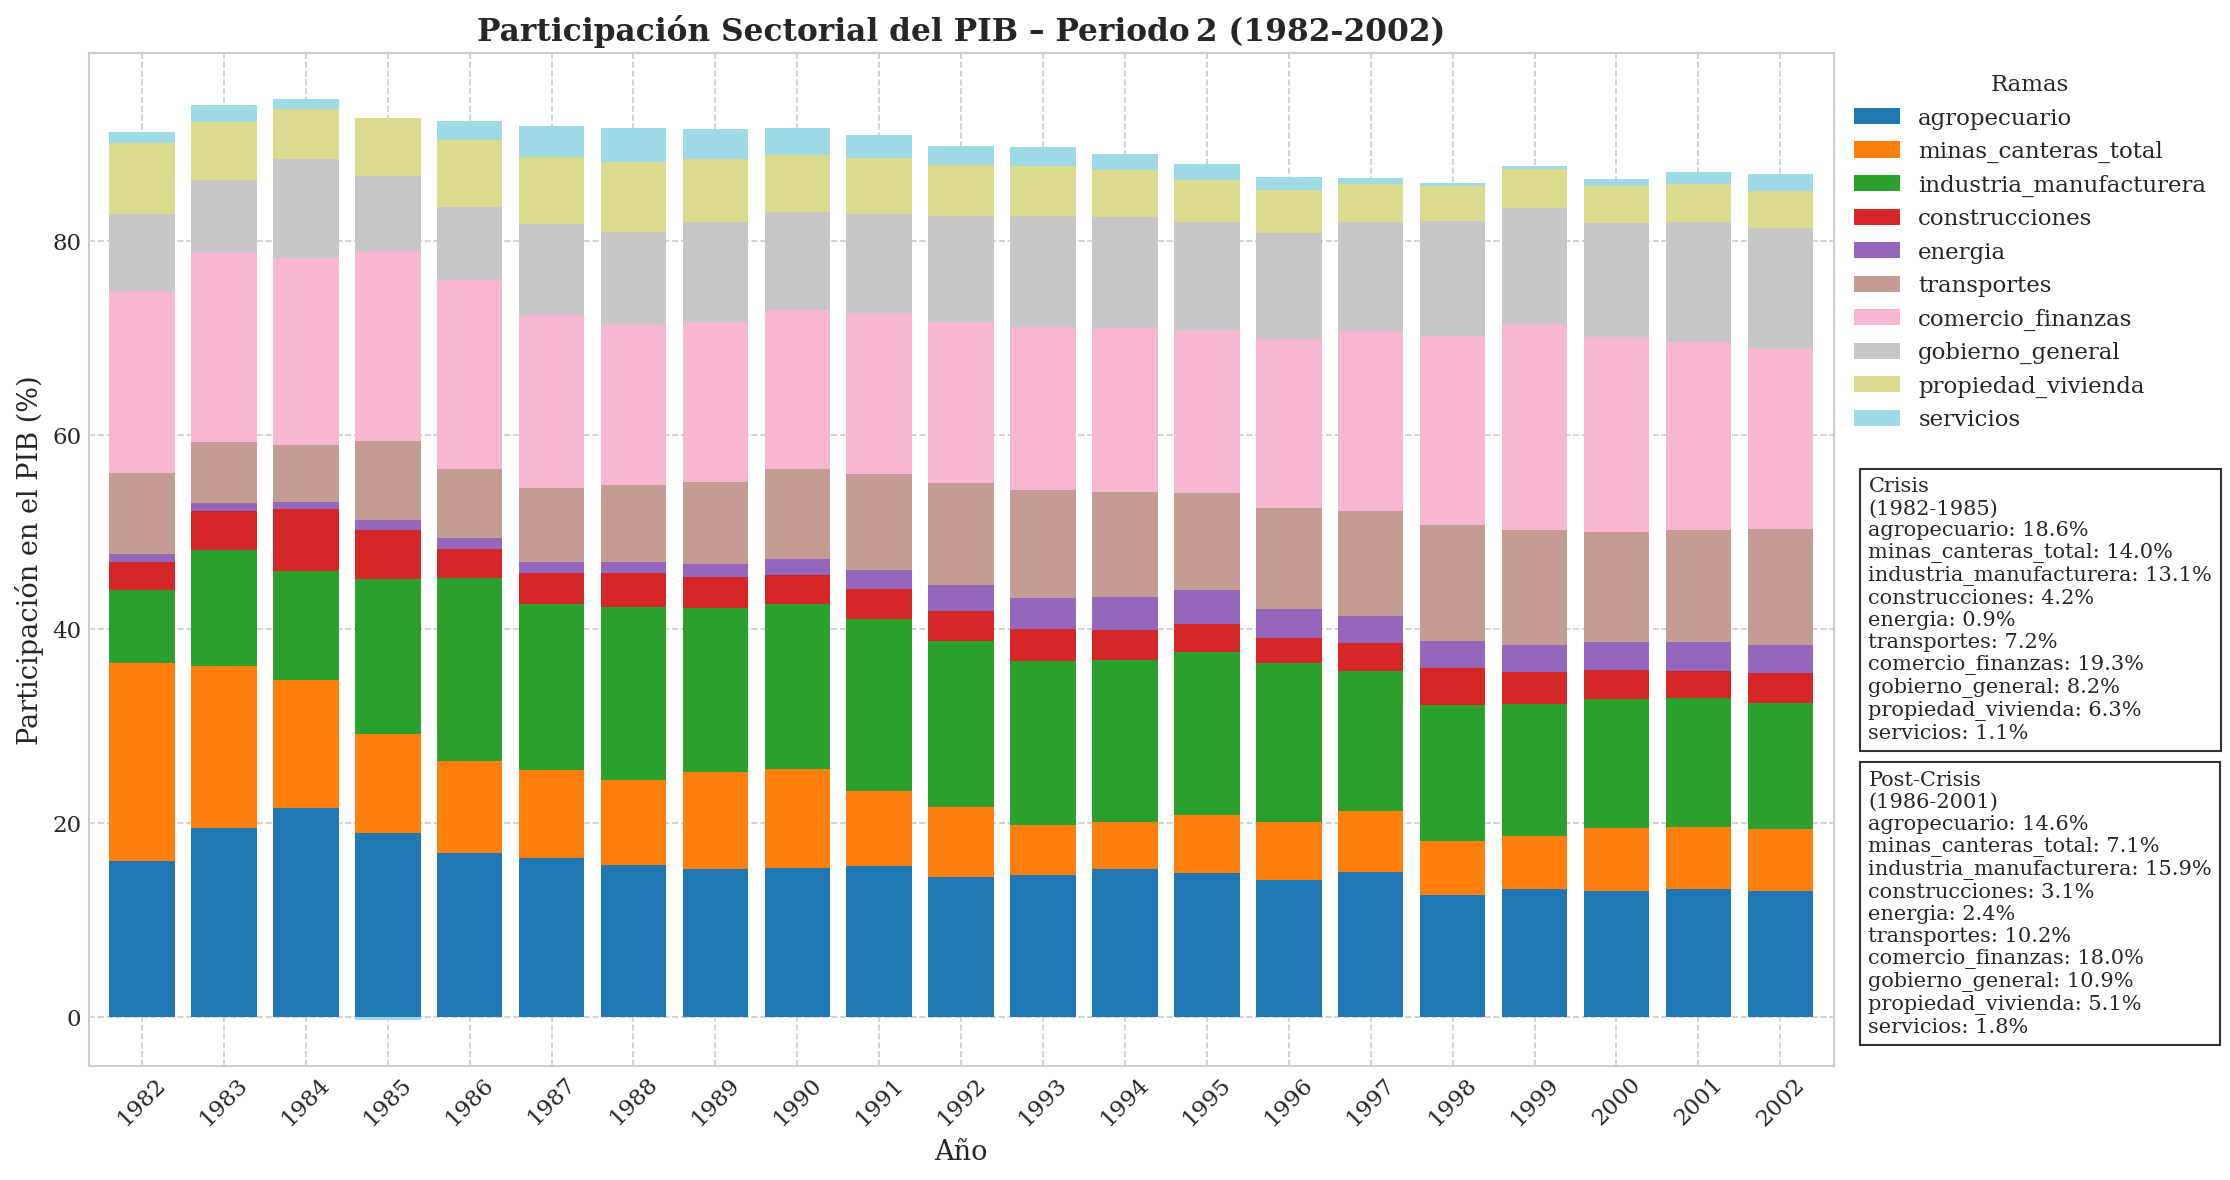

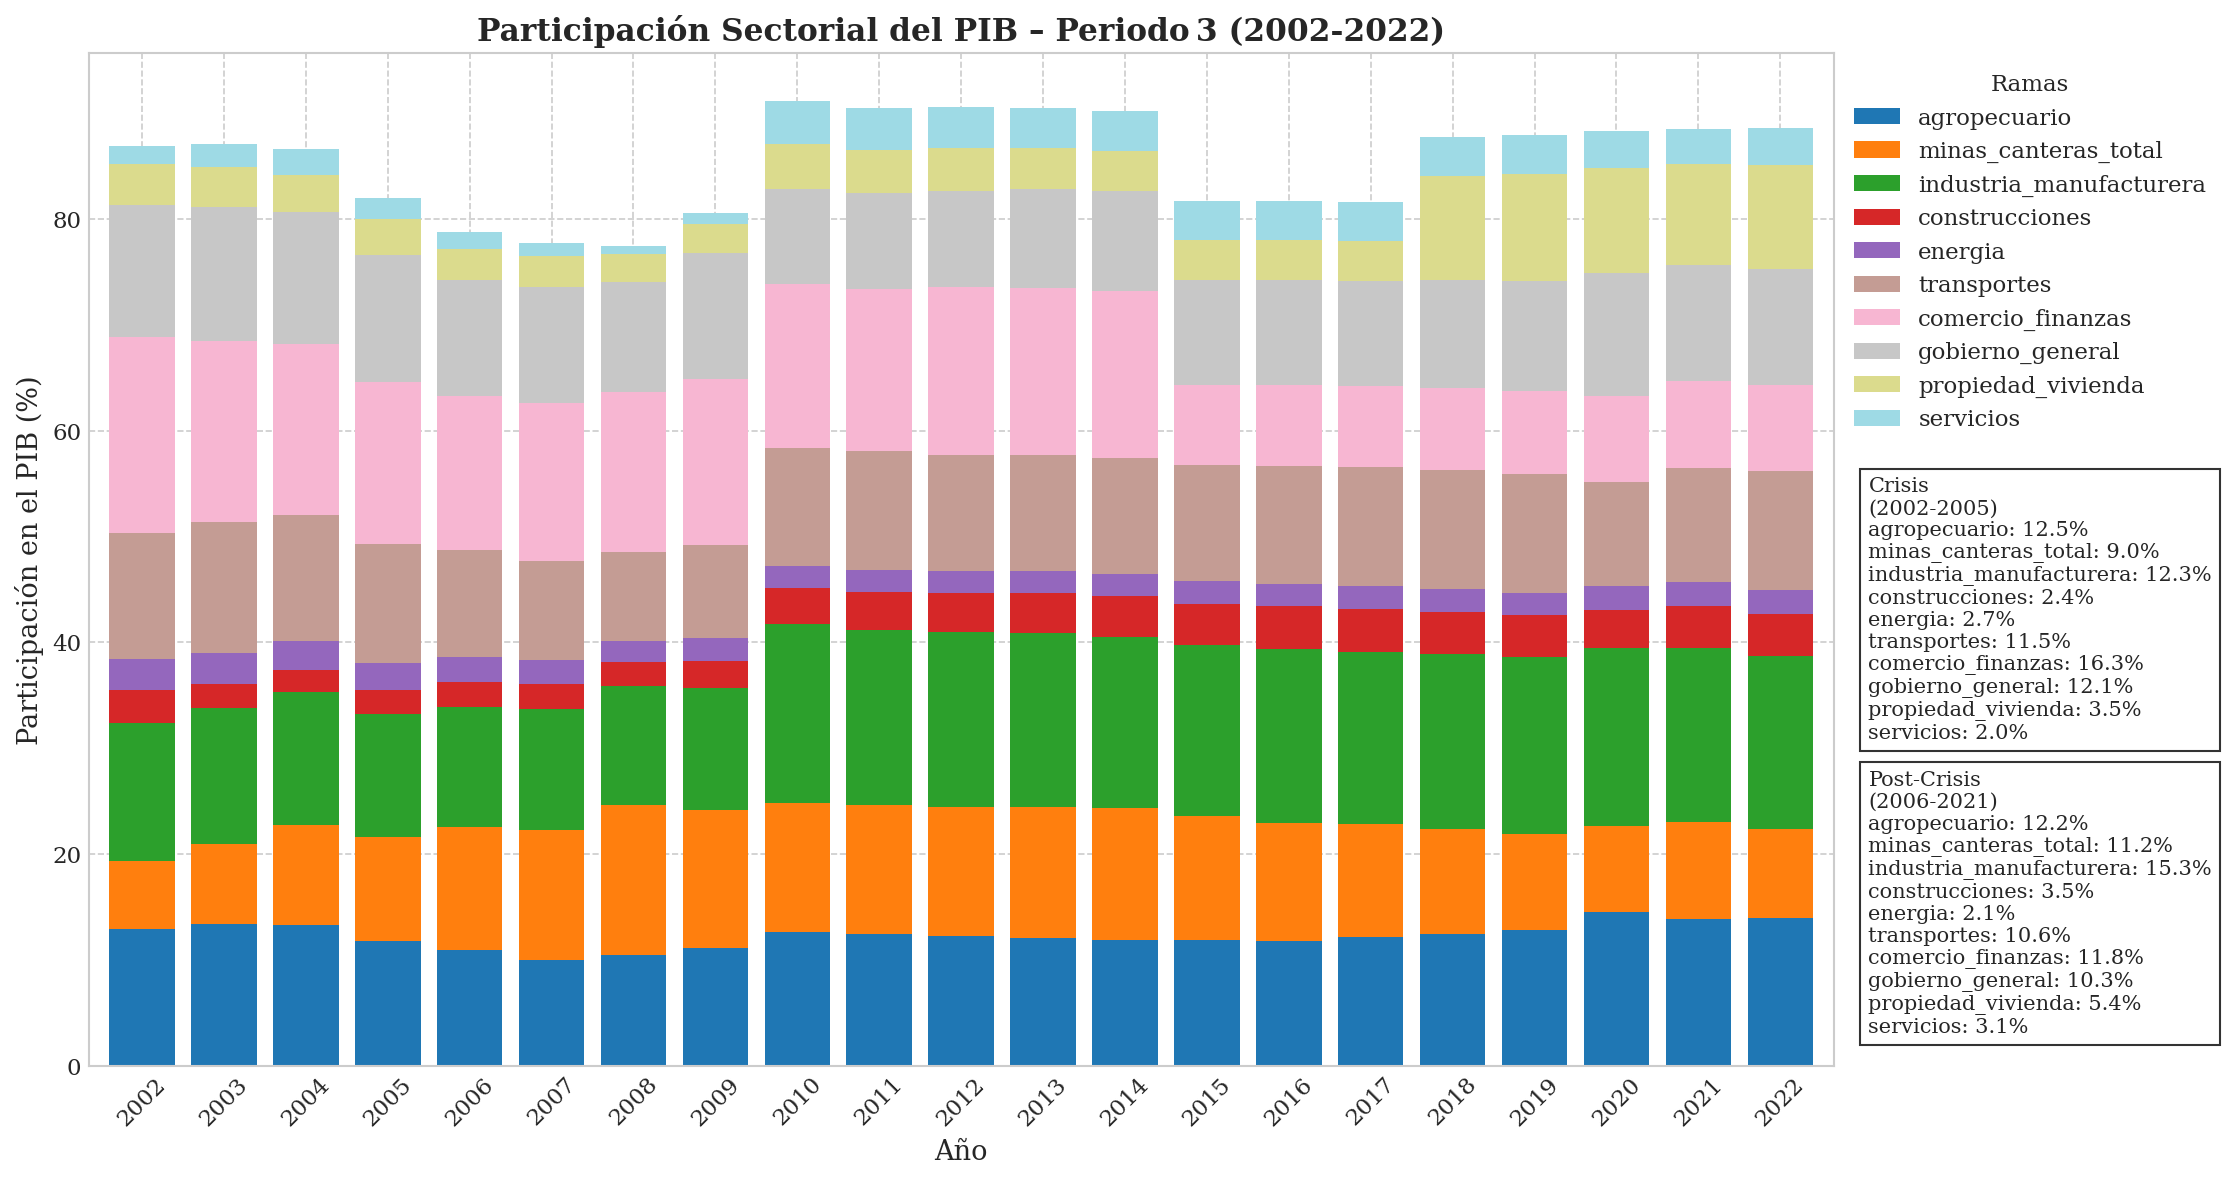

✔️   Gráficos guardados en: ../../assets/tesis/participacion_ramas


In [8]:
# ======================  ANALISIS DE PARTICIPACIÓN POR RAMA  ======================
#
#  Requiere una base SQLite con la tabla `pib_ramas`
#  (columnas: año, agropecuario, minas_canteras_total, … , pib_nominal)
#
#  Ajusta DB_PATH y OUTPUT_DIR según tu proyecto.
# ================================================================================

import sqlite3, os, pandas as pd
import matplotlib.pyplot as plt

# ── 1. Config ───────────────────────────────────────────────────────────────────
DB_PATH     = "../../db/proyectomacro.db"
OUTPUT_DIR  = "../../assets/tesis/participacion_ramas"
os.makedirs(OUTPUT_DIR, exist_ok=True)

STYLING = {
    'font.family'    : 'serif',
    'font.size'      : 11,
    'axes.titlesize' : 15,
    'axes.labelsize' : 13,
    'grid.linestyle' : '--',
    'lines.linewidth': 2,
    'figure.dpi'     : 150,
    'savefig.bbox'   : 'tight'
}
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update(STYLING)

# ── 2. Definición de periodos ───────────────────────────────────────────────────
PERIODS = {
    "Periodo 1 (1952‑1982)" : {
        "years"  : slice(1952, 1982),
        "crisis" : slice(1952, 1956),   # 52‑55
        "post"   : slice(1956, 1982)    # 56‑82
    },
    "Periodo 2 (1982‑2002)" : {
        "years"  : slice(1982, 2002),
        "crisis" : slice(1982, 1986),   # 82‑85
        "post"   : slice(1986, 2002)    # 86‑02
    },
    "Periodo 3 (2002‑2022)" : {
        "years"  : slice(2002, 2022),
        "crisis" : slice(2002, 2006),   # 02‑05
        "post"   : slice(2006, 2022)    # 06‑22
    }
}

# ── 3. Cargar datos ─────────────────────────────────────────────────────────────
with sqlite3.connect(DB_PATH) as conn:
    df = pd.read_sql_query("SELECT * FROM pib_ramas", conn, index_col="año")

# Campos de actividad (todas menos totales)
componentes = [
    'agropecuario','minas_canteras_total','industria_manufacturera',
    'construcciones','energia','transportes','comercio_finanzas',
    'gobierno_general','propiedad_vivienda','servicios'
]

# ── 4. Función para un periodo ─────────────────────────────────────────────────
def plot_period(nombre:str, conf:dict):
    sub   = df.loc[conf["years"]].copy()
    pct   = sub[componentes].div(sub["pib_nominal"], axis=0) * 100

    # promedios
    avg_crisis = pct.loc[conf["crisis"]].mean()
    avg_post   = pct.loc[conf["post"]  ].mean()

    # gráfico
    fig, ax = plt.subplots(figsize=(15,8))
    pct.plot(kind="bar", stacked=True, ax=ax, width=0.8,
             colormap="tab20")   # 20 colores distintos

    ax.set_ylabel("Participación en el PIB (%)")
    ax.set_xlabel("Año")
    ax.set_title(f"Participación Sectorial del PIB – {nombre}", fontweight="bold")
    ax.legend(title="Ramas", loc="upper left", bbox_to_anchor=(1,1))
    plt.xticks(rotation=45)

    # textos de resumen
    stats_c = "\n".join(f"{k}: {v:.1f}%" for k,v in avg_crisis.items())
    stats_p = "\n".join(f"{k}: {v:.1f}%" for k,v in avg_post.items())

    ax.text(1.02, 0.45, f"Crisis\n({conf['crisis'].start}‑{conf['crisis'].stop-1})\n"+stats_c,
            transform=ax.transAxes, fontsize=10, va="center", bbox=dict(fc="white", ec="k", alpha=.8))

    ax.text(1.02, 0.16, f"Post‑Crisis\n({conf['post'].start}‑{conf['post'].stop-1})\n"+stats_p,
            transform=ax.transAxes, fontsize=10, va="center", bbox=dict(fc="white", ec="k", alpha=.8))

    plt.tight_layout()
    out = os.path.join(OUTPUT_DIR, f"pib_ramas_{nombre.replace(' ','_')}.png")
    plt.savefig(out, dpi=300)
    plt.show()

# ── 5. Ejecutar para cada periodo ──────────────────────────────────────────────
for nombre, conf in PERIODS.items():
    plot_period(nombre, conf)

print("✔️   Gráficos guardados en:", OUTPUT_DIR)